In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import xarray as xr
import random
import os
%load_ext rpy2.ipython

In [2]:
%%R
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
%%R
df1 <- read_delim('../results/tajimasd/combined_all/all_species_combined.csv',delim='\t') %>%  na.omit() %>% filter(freq_mean > 0.5) %>%
    group_by(genus,species) %>% filter(!(chr=='chrX')) %>% mutate(recombin= ntile(cm_per_mb,20))

Rows: 5421303 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (3): chr, species, genus
dbl (13): start, end, freq_mean, freq_min, freq_max, freq_median, window_siz...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


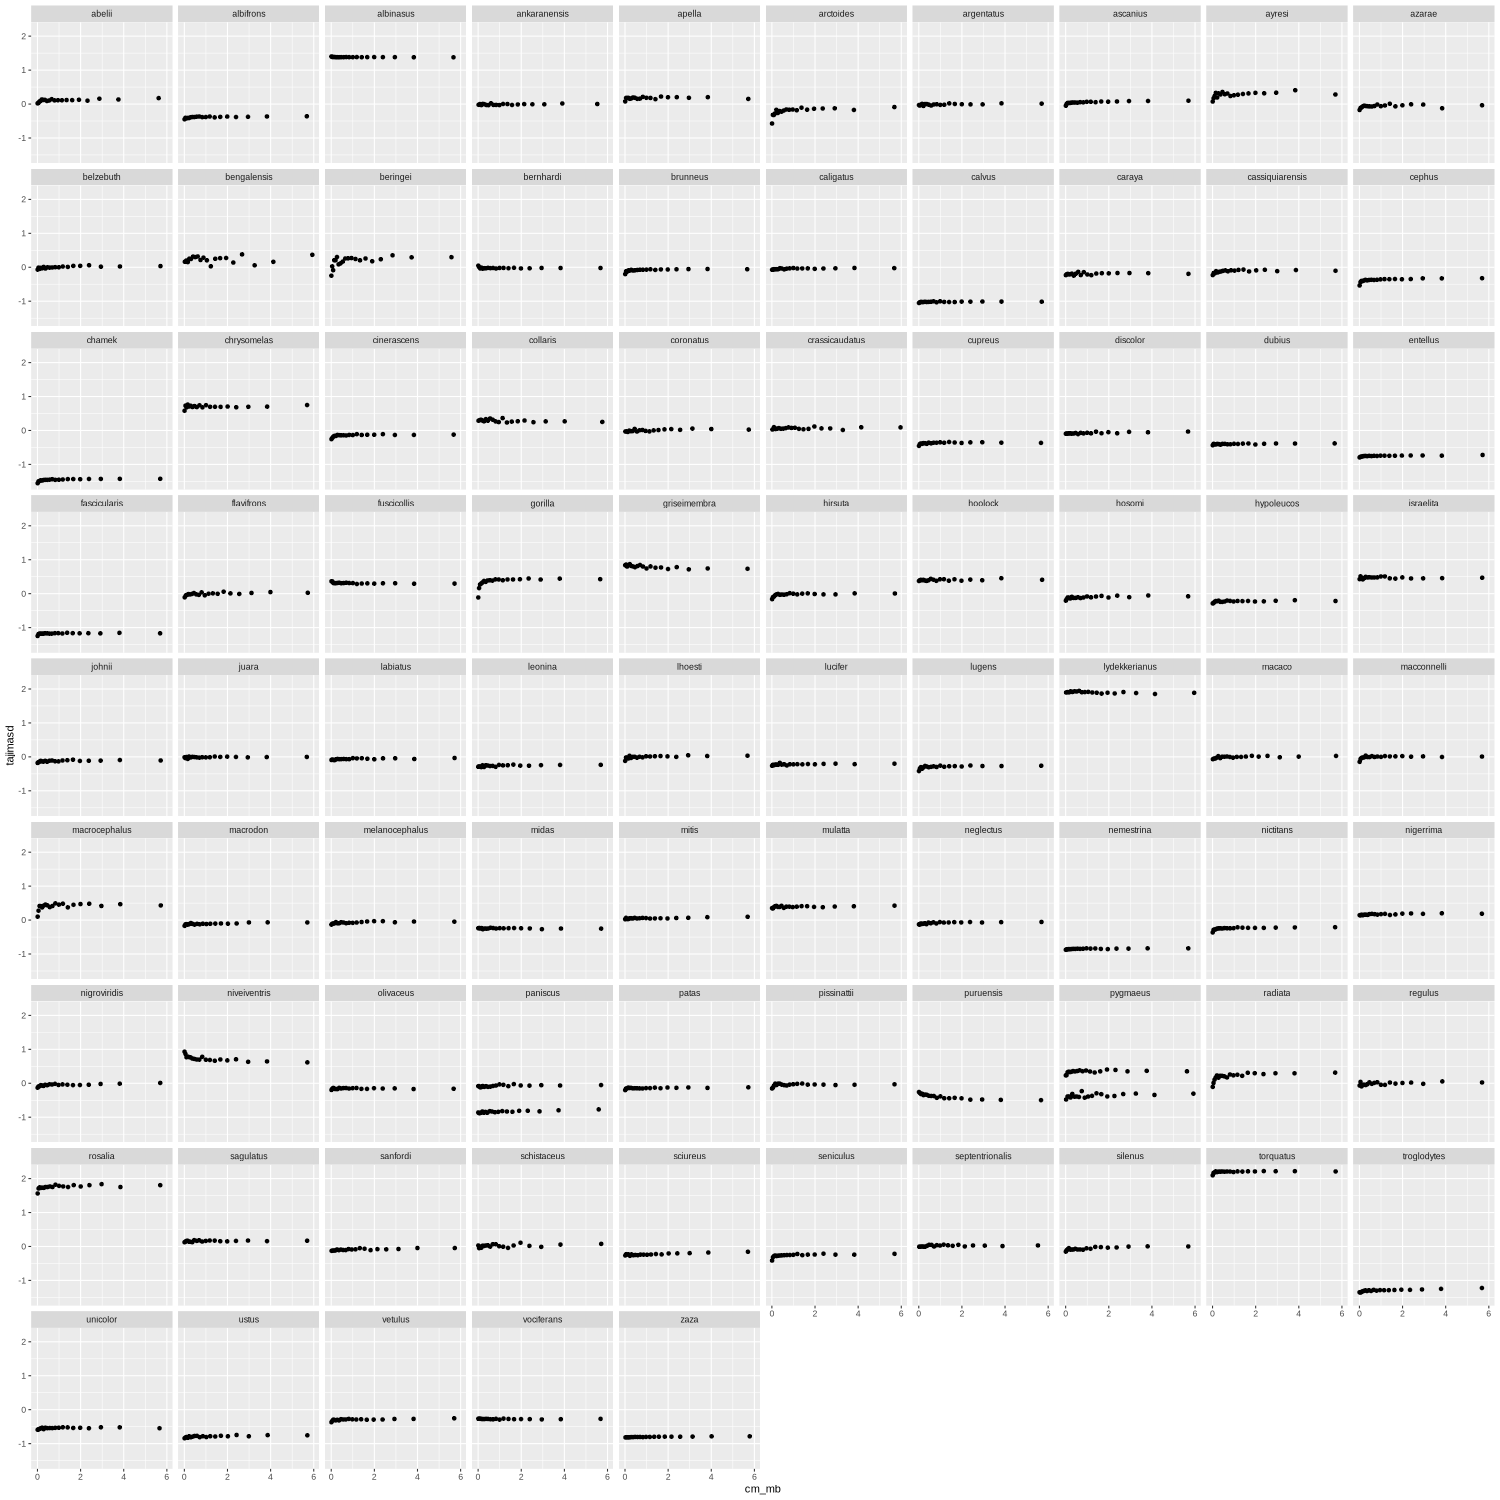

In [4]:
%%R -h 1500 -w 1500
df1 %>% group_by(genus,species,recombin) %>%
    reframe(
        cm_mb = median(cm_per_mb),
        tajimasd= median(TajimaD)) %>%
    ggplot(aes(x=cm_mb, y = tajimasd))+
    geom_point()+
    facet_wrap(species~.)

In [5]:
%%R
count <- read_delim('../data/PDGP_metadata.txt',delim=',')
count

Rows: 810 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): PDGP_ID, Genus, Species, FROH, Sex, ref_assembly

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 810 × 6
   PDGP_ID Genus      Species      FROH       Sex   ref_assembly      
   <chr>   <chr>      <chr>        <chr>      <chr> <chr>             
 1 PD_0001 Cheracebus lugens       0.02829385 F     Pithecia_pithecia 
 2 PD_0002 Callibella humilis      0.00991667 M     Callithrix_jacchus
 3 PD_0003 Cacajao    hosomi       0.06922806 M     Pithecia_pithecia 
 4 PD_0004 Ateles     belzebuth    0.08438225 F     Atele_fusciceps   
 5 PD_0005 Alouatta   macconnelli  0.06254126 M     Atele_fusciceps   
 6 PD_0006 Chiropotes israelita    0.03880299 F     Pithecia_pithecia 
 7 PD_0007 Cebus      olivaceus    0.02831854 U     Cebus_albifrons   
 8 PD_0008 

In [20]:
%%R
above <- count %>%
    group_by(Genus,Species,ref_assembly) %>%
    reframe(
        n = n(),
        froh_mean = mean(as.double(FROH))
    ) %>% filter(n > 3)

In [21]:
%%R
print(above,n=28)

# A tibble: 47 × 5
   Genus         Species      ref_assembly                n froh_mean
   <chr>         <chr>        <chr>                   <int>     <dbl>
 1 Alouatta      macconnelli  Atele_fusciceps             5   0.0393 
 2 Alouatta      puruensis    Atele_fusciceps             6   0.0824 
 3 Alouatta      seniculus    Atele_fusciceps            15   0.0336 
 4 Aotus         azarae       Aotus_nancymaae            14   0.265  
 5 Aotus         griseimembra Aotus_nancymaae             4   0.185  
 6 Aotus         vociferans   Aotus_nancymaae             5   0.00566
 7 Ateles        chamek       Atele_fusciceps            11   0.0256 
 8 Cacajao       calvus       Pithecia_pithecia          19   0.115  
 9 Cebus         unicolor     Cebus_albifrons             4   0.0257 
10 Cercopithecus ascanius     Cercopithecus_mitis         4   0.0174 
11 Cheracebus    lucifer      Pithecia_pithecia           4   0.0256 
12 Cheracebus    lugens       Pithecia_pithecia           8   0.0451 
1

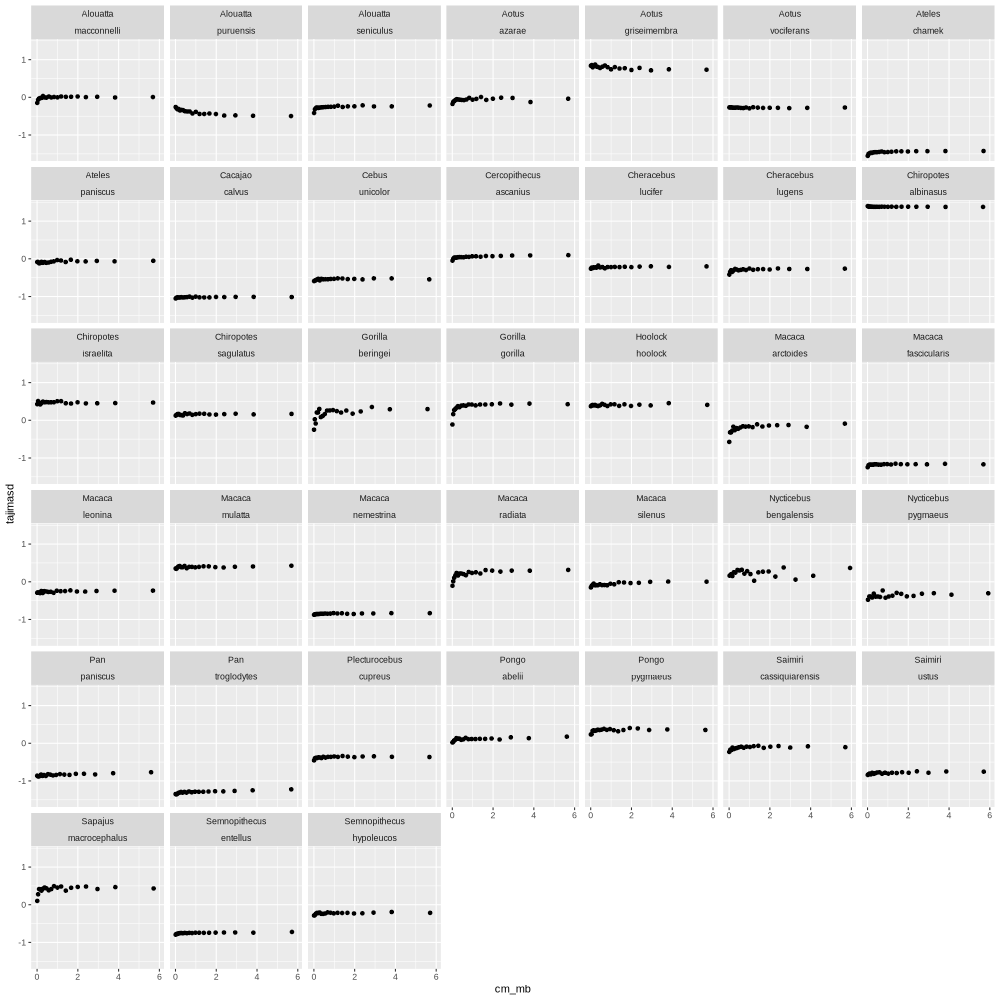

In [22]:
%%R -h 1000 -w 1000
df1 %>% filter(species %in% c(above$Species)) %>%
    filter(genus %in% c(above$Genus)) %>% 
    group_by(genus,species,recombin) %>%
    reframe(
        cm_mb = median(cm_per_mb),
        tajimasd= median(TajimaD)) %>%
    ggplot(aes(x=cm_mb, y = tajimasd))+
    geom_point()+
    facet_wrap(genus~species)


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


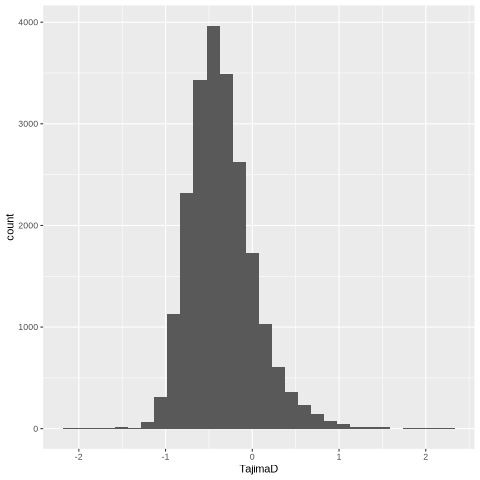

In [23]:
%%R
df1 %>% filter(species=='puruensis') %>% 
    ggplot(aes(x=TajimaD))+
    geom_histogram()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


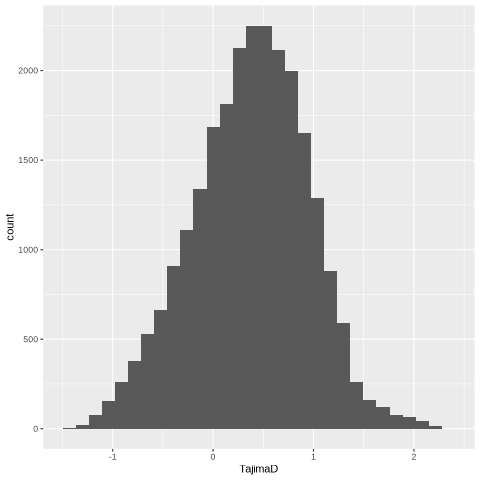

In [24]:
%%R
df1 %>% filter(species=='hoolock') %>% 
    ggplot(aes(x=TajimaD))+
    geom_histogram()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


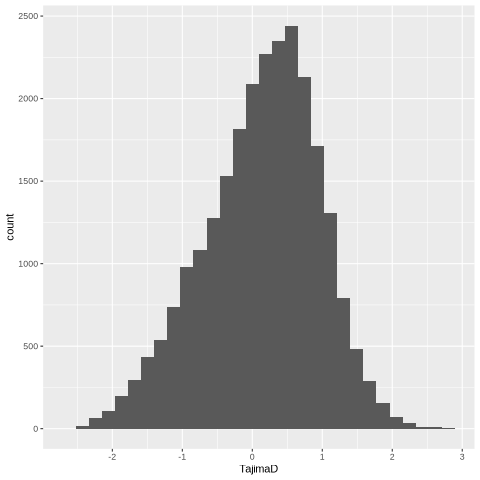

In [25]:
%%R
df1 %>% filter(species=='radiata') %>% 
    ggplot(aes(x=TajimaD))+
    geom_histogram()

In [26]:
%%R
nes <- read_delim('../results/model/Nested_model/Ne_Pi_recomb.csv', delim = ',') %>% select('genus','species','NE_MEAN','NE_VARIANCE','NE_MEDIAN')


New names:
• `` -> `...1`
Rows: 5071829 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): genus, species, FAMILY, chr
dbl (21): ...1, Unnamed: 0, MEAN, MEDIAN, VARIANCE, NE_MEAN, NE_MEDIAN, NE_V...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [27]:
%%R
dfabove <- df1 %>% filter(species %in% c(above$Species)) %>%
    filter(genus %in% c(above$Genus)) 

In [28]:
%%R
nes$name <- paste0(nes$genus,'_',nes$species)
nes <- distinct(nes,name,.keep_all = TRUE)
nes

# A tibble: 187 × 6
   genus          species      NE_MEAN  NE_VARIANCE NE_MEDIAN name              
   <chr>          <chr>          <dbl>        <dbl>     <dbl> <chr>             
 1 Allenopithecus nigroviridis  52454.  6495221817.    48795. Allenopithecus_ni…
 2 Allochrocebus  lhoesti       91523. 32298789853.    83266. Allochrocebus_lho…
 3 Allochrocebus  preussi       98962.  6145338407.    91644. Allochrocebus_pre…
 4 Allochrocebus  solatus      110522.  3179447726.   101523. Allochrocebus_sol…
 5 Alouatta       belzebul      59406.  3334358722.    54570. Alouatta_belzebul 
 6 Alouatta       caraya        37473. 35520350568.    35650. Alouatta_caraya   
 7 Alouatta       discolor      75638. 25634863197.    66639. Alouatta_discolor 
 8 Alouatta       juara         70735.  1041550723.    65093. Alouatta_juara    
 9 Alouatta       macconnelli   67134.  3186822159.    61665. Alouatta_macconne…
10 Alouatta       nigerrima     69902.  7463261304.    64414. Alouatta_nigerrima
# ℹ 177 

In [29]:
%%R
dfne <- left_join(dfabove,nes,by=c('genus'='genus','species'='species'))

In [30]:
%%R
dfne

# A tibble: 893,390 × 21
# Groups:   genus, species [38]
   chr     start    end freq_mean freq_min freq_max freq_median window_size_mean
   <chr>   <dbl>  <dbl>     <dbl>    <dbl>    <dbl>       <dbl>            <dbl>
 1 chr1  1600000 1.7 e6     0.605    0.162    0.721       0.679           100000
 2 chr1  1800000 1.9 e6     0.731    0.197    0.840       0.812           100000
 3 chr1  1900000 2   e6     0.680    0.242    0.794       0.755           100000
 4 chr1  2000000 2.10e6     0.698    0.285    0.800       0.762           100000
 5 chr1  2100000 2.20e6     0.712    0.292    0.820       0.774           100000
 6 chr1  2200000 2.3 e6     0.729    0.223    0.867       0.811           100000
 7 chr1  2300000 2.40e6     0.723    0.288    0.839       0.794           100000
 8 chr1  2400000 2.5 e6     0.756    0.373    0.884       0.848           100000
 9 chr1  2500000 2.6 e6     0.696    0.248    0.834       0.780           100000
10 chr1  2800000 2.90e6     0.782    0.411    0.881 

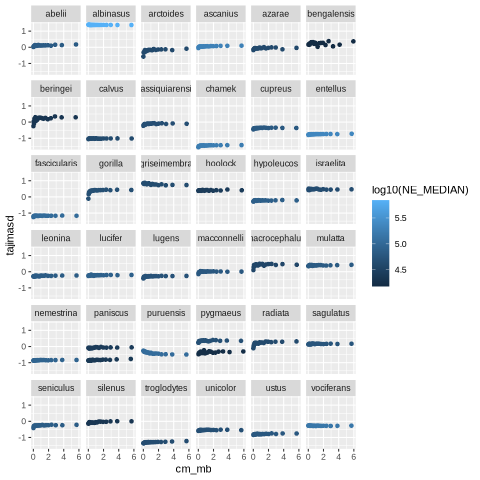

In [31]:
%%R
dfne %>% group_by(genus,species,recombin) %>%
    reframe(
        cm_mb = median(cm_per_mb),
        tajimasd= median(TajimaD),
        NE_MEDIAN = median(NE_MEDIAN)) %>%
    ggplot(aes(x=cm_mb, y = tajimasd, col = log10(NE_MEDIAN)))+
    geom_point()+
    facet_wrap(species~.)

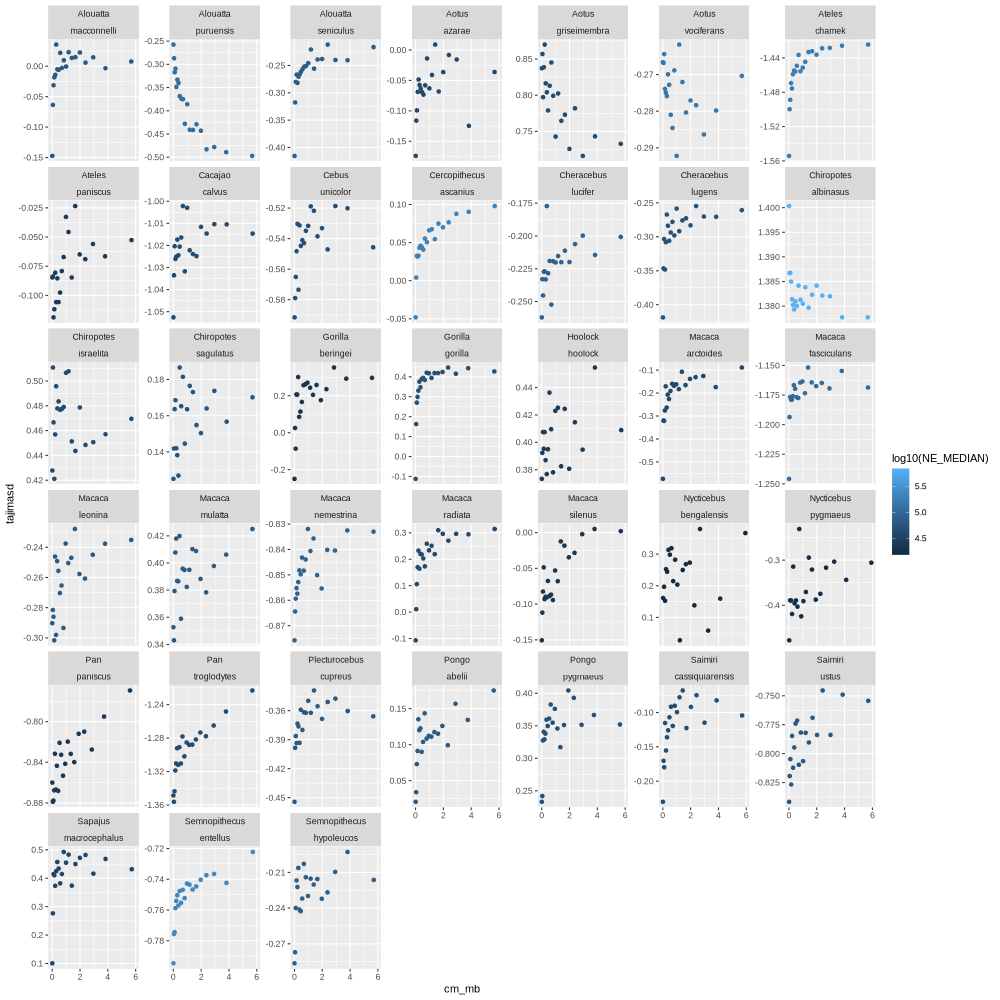

In [33]:
%%R -h 1000 -w 1000
dfne %>% group_by(genus,species,recombin) %>%
    #filter(!(species %in% c('albinasus', 'puruensis'))) %>%
    reframe(
        cm_mb = median(cm_per_mb),
        tajimasd= median(TajimaD),
        NE_MEDIAN = median(NE_MEDIAN)) %>%
    ggplot(aes(x=cm_mb, y = tajimasd, col = log10(NE_MEDIAN)))+
    geom_point()+
    facet_wrap(genus~species, scales = 'free_y')